In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.2 MB/s eta 0:00:00


**LABELING PAKEK LEXSICON**

In [ ]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')
folder_utama = '/content/drive/MyDrive/Ruangguru/'

path_dataset   = folder_utama + 'dataset.xlsx'
path_kamus_pos = folder_utama + 'positive.txt'
path_kamus_neg = folder_utama + 'negative.txt'
path_slang     = folder_utama + 'slang_indo.csv'

NAMA_KOLOM_TEKS = 'text'
3
# ==========================================
# 2. LOAD DATA & KAMUS
# ==========================================
if os.path.exists(path_slang) and os.path.exists(path_dataset):
    print("Sedang meload data...")

    # Load Dataset Utama
    df = pd.read_excel(path_dataset)
    print(f"Dataset berhasil di-load: {len(df)} baris data.")

    # Load Kamus Slang dari CSV
    try:
        df_slang = pd.read_csv(path_slang, header=None, names=['alay', 'baku'])
        kamus_slang = dict(zip(df_slang['alay'], df_slang['baku']))
        print("Kamus slang CSV berhasil di-load.")
    except Exception as e:
        print(f"Gagal load slang: {e}")
        kamus_slang = {}

    # Tambahkan kata-kata manual
    kamus_tambahan = {
    # Kata ganti & Sapaan
    'ak': 'saya', 'aku': 'saya', 'sy': 'saya', 'gw': 'saya', 'gua': 'saya', 'gwe': 'saya',
    'km': 'kamu', 'lu': 'kamu', 'lo': 'kamu',
    'pk': 'bapak', 'pak': 'bapak', 'bpk': 'bapak',
    'kak': 'kakak', 'kk': 'kakak', 'kaka': 'kakak',
    'min': 'admin', 'mimin': 'admin',
    'ortu': 'orang tua',
    'ank': 'anak', 'adk': 'adik',

    # Kata Kerja & Keterangan
    'yg': 'yang',
    'gak': 'tidak', 'nggak': 'tidak', 'ga': 'tidak', 'enggak': 'tidak', 'gk': 'tidak', 'g': 'tidak',
    'sdh': 'sudah', 'udh': 'sudah', 'dah': 'sudah',
    'bkn': 'bukan',
    'jgn': 'jangan',
    'dgn': 'dengan',
    'dr': 'dari', 'dri': 'dari',
    'utk': 'untuk',
    'dlm': 'dalam',
    'klo': 'kalau', 'kalo': 'kalau',
    'bgt': 'sangat', 'banget': 'sangat', 'bngtt': 'sangat',
    'aja': 'saja', 'aj': 'saja',
    'sm': 'sama', 'sma': 'sama',
    'krn': 'karena', 'karna': 'karena', 'krna': 'karena',
    'tp': 'tapi', 'tpi': 'tapi',
    'blm': 'belum', 'lom': 'belum',
    'jg': 'juga', 'jga': 'juga',
    'trs': 'terus', 'trus': 'terus',
    'jd': 'jadi', 'jdi': 'jadi',
    'lbh': 'lebih',
    'bs': 'bisa', 'bsa': 'bisa',
    'tau': 'tahu',
    'mau': 'ingin', # Tergantung konteks, tapi seringkali 'ingin'
    'dpt': 'dapat', 'dapet': 'dapat',
    'pake': 'pakai',
    'mnrt': 'menurut',
    'org': 'orang',
    'dtg': 'datang',
    'ni': 'ini', 'nih': 'ini',
    'tu': 'itu', 'tuh': 'itu',
    'gini': 'begini', 'gitu': 'begitu', 'gt': 'begitu',
    'emg': 'memang', 'emang': 'memang',

    # Kata Benda & Spesifik Aplikasi
    'rp': 'rupiah',
    'telp': 'telepon', 'tlp': 'telepon',
    'apk': 'aplikasi', 'apps': 'aplikasi', 'app': 'aplikasi',
    'mapel': 'mata pelajaran',
    'mtk': 'matematika',
    'pr': 'pekerjaan rumah',
    'bljr': 'belajar',
    'smngt': 'semangat',
    'bgs': 'bagus', 'baguss': 'bagus',
    'mks': 'terima kasih', 'makasih': 'terima kasih', 'trims': 'terima kasih', 'trimakasih': 'terima kasih', 'tks': 'terima kasih',
    'kmrn': 'kemarin',
    'skrng': 'sekarang',
    'br': 'baru',
    'lgsg': 'langsung',
}
    kamus_slang.update(kamus_tambahan)
    print(f"Kamus lengkap siap. Total kata: {len(kamus_slang)}")

    # Load Kamus Sentimen
    try:
        with open(path_kamus_pos, 'r', encoding='utf-8', errors='ignore') as f:
            positive_words = set(f.read().splitlines())
        with open(path_kamus_neg, 'r', encoding='utf-8', errors='ignore') as f:
            negative_words = set(f.read().splitlines())
        print("Kamus sentimen berhasil di-load.")
    except Exception as e:
        print(f"Gagal load kamus sentimen: {e}")
        positive_words = set()
        negative_words = set()

    # ==========================================
    # 3. FUNGSI PREPROCESSING
    # ==========================================
    def clean_and_normalize(text):
        if not isinstance(text, str):
            return ""

        text = text.lower()
        # Hapus huruf berulang
        text = re.sub(r'(\w)\1{2,}', r'\1', text)
        # Hapus angka dan tanda baca
        text = re.sub(r'[^a-z\s]', ' ', text)

        words = text.split()
        # Normalisasi slang
        normalized_words = [kamus_slang.get(word, word) for word in words]

        # (Opsional) Hapus kata yang terlalu pendek (1 huruf) agar visualisasi bersih
        normalized_words = [w for w in normalized_words if len(w) > 1]

        return ' '.join(normalized_words)

    # ==========================================
    # 4. FUNGSI AUTO LABELING
    # ==========================================
    def get_sentiment_score(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1

        if score > 0: return 'Positif'
        elif score < 0: return 'Negatif'
        else: return 'Netral'

    # ==========================================
    # 5. EKSEKUSI PROSES
    # ==========================================
    print("Sedang memproses teks... (Tunggu sebentar)")
    df['text_clean'] = df[NAMA_KOLOM_TEKS].apply(clean_and_normalize)
    df['sentiment_pred'] = df['text_clean'].apply(get_sentiment_score)

    # Simpan hasil
    output_path = folder_utama + 'dataset_label.xlsx'
    df.to_excel(output_path, index=False)
    print(f"\n✅ File Excel disimpan di: {output_path}")


else:
    print("\n⛔ Program berhenti karena file tidak lengkap. Silakan cek folder Google Drive Anda.")

Mounted at /content/drive
Sedang meload data...
Dataset berhasil di-load: 14536 baris data.
Kamus slang CSV berhasil di-load.
Kamus lengkap siap. Total kata: 1276
Kamus sentimen berhasil di-load.
Sedang memproses teks... (Tunggu sebentar)

✅ File Excel disimpan di: /content/drive/MyDrive/Ruangguru/dataset_label.xlsx


IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


DATA UNDERSTANDING & LABEL CLEANING

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Ruangguru/dataset_label.xlsx")
df.head()

,text,text_clean,Label
0,"nama saya Adit, saya download ruang guru cuma ...",nama saya adit saya download ruang guru cuma b...,Netral
1,Baik ini sangat baik karena singkron dengan er...,baik ini sangat baik karena singkron dengan er...,Positif
2,pengen lbh memahami mapel matematika utk,ingin lebih memahami mata pelajaran matematika...,Netral
3,Berikan waktu mu sejenak untuk belajar,berikan waktu mu sejenak untuk belajar,Netral
4,aplikasi ini sangat berguna,aplikasi ini sangat berguna,Positif


In [ ]:
print(df['Label'].unique())

['Netral' 'Positif' 'Negatif']


PREPROCESSING TEXT

In [ ]:
teks_kolom = 'text'
df[[teks_kolom]].head()

,text
0,"nama saya Adit, saya download ruang guru cuma ..."
1,Baik ini sangat baik karena singkron dengan er...
2,pengen lbh memahami mapel matematika utk
3,Berikan waktu mu sejenak untuk belajar
4,aplikasi ini sangat berguna


CASE FOLDING

In [ ]:
df['case_folding'] = df[teks_kolom].astype(str).str.lower()
df[[teks_kolom, 'case_folding']].head()

,text,case_folding
0,"nama saya Adit, saya download ruang guru cuma ...","nama saya adit, saya download ruang guru cuma ..."
1,Baik ini sangat baik karena singkron dengan er...,baik ini sangat baik karena singkron dengan er...
2,pengen lbh memahami mapel matematika utk,pengen lbh memahami mapel matematika utk
3,Berikan waktu mu sejenak untuk belajar,berikan waktu mu sejenak untuk belajar
4,aplikasi ini sangat berguna,aplikasi ini sangat berguna


CLEAN KARAKTER

In [ ]:
def clean_text(text):
    #Hapus URL (http, https, www)
    text = re.sub(r'http\S+|www\S+', '', text)
    #Hapus emoji dan karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    #Hapus angka & simbol (biarkan huruf dan spasi saja)
    text = re.sub(r'[^a-z\s]', '', text)
    #Hapus spasi berlebih (lebih dari satu spasi)
    text = re.sub(r'\s+', ' ', text)
    #Hapus spasi di awal & akhir
    text = text.strip()
    return text

df['clean'] = df['case_folding'].apply(clean_text)
df[['case_folding', 'clean']].head()

,case_folding,clean
0,"nama saya adit, saya download ruang guru cuma ...",nama saya adit saya download ruang guru cuma b...
1,baik ini sangat baik karena singkron dengan er...,baik ini sangat baik karena singkron dengan er...
2,pengen lbh memahami mapel matematika utk,pengen lbh memahami mapel matematika utk
3,berikan waktu mu sejenak untuk belajar,berikan waktu mu sejenak untuk belajar
4,aplikasi ini sangat berguna,aplikasi ini sangat berguna


TOKENISASI

In [ ]:
df['tokenisasi'] = df['clean'].apply(word_tokenize)
df[['clean', 'tokenisasi']].head()

,clean,tokenisasi
0,nama saya adit saya download ruang guru cuma b...,"[nama, saya, adit, saya, download, ruang, guru..."
1,baik ini sangat baik karena singkron dengan er...,"[baik, ini, sangat, baik, karena, singkron, de..."
2,pengen lbh memahami mapel matematika utk,"[pengen, lbh, memahami, mapel, matematika, utk]"
3,berikan waktu mu sejenak untuk belajar,"[berikan, waktu, mu, sejenak, untuk, belajar]"
4,aplikasi ini sangat berguna,"[aplikasi, ini, sangat, berguna]"


NORMALISASI SLANG

In [ ]:
slang_df = pd.read_csv('/content/drive/MyDrive/Ruangguru/slang_indo.csv')
slang_dict = dict(zip(slang_df.iloc[:,0], slang_df.iloc[:,1]))
print(f"Total kata slang: {len(slang_dict)}")

list(slang_dict.items())[:10]

Total kata slang: 1249


[('adek', 'adik '),
 ('adlh', 'adalah '),
 ('aer', 'air '),
 ('aiskrim', 'es krim '),
 ('aj', 'saja '),
 ('aja', 'saja '),
 ('ajah', 'saja '),
 ('ajalah', 'saja '),
 ('aje', 'saja '),
 ('ajh', 'saja')]

In [ ]:
def normalize_slang(tokens):
    return [slang_dict.get(word, word) for word in tokens]

df['normalisasi'] = df['tokenisasi'].apply(normalize_slang)
df[['tokenisasi', 'normalisasi']].head()

,tokenisasi,normalisasi
0,"[nama, saya, adit, saya, download, ruang, guru...","[nama, saya, adit, saya, download, ruang, guru..."
1,"[baik, ini, sangat, baik, karena, singkron, de...","[baik, ini, sangat, baik, karena, singkron, de..."
2,"[pengen, lbh, memahami, mapel, matematika, utk]","[ingin, lebih , memahami, mapel, matematika, u..."
3,"[berikan, waktu, mu, sejenak, untuk, belajar]","[berikan, waktu, mu, sejenak, untuk, belajar]"
4,"[aplikasi, ini, sangat, berguna]","[aplikasi, ini, sangat, berguna]"


STOPWORD

In [ ]:
stop_words = set(stopwords.words('indonesian'))

df['stopwords'] = df['normalisasi'].apply(
    lambda words: [w for w in words if w not in stop_words])
df[['normalisasi', 'stopwords']].head()

,normalisasi,stopwords
0,"[nama, saya, adit, saya, download, ruang, guru...","[nama, adit, download, ruang, guru, nonton, co..."
1,"[baik, ini, sangat, baik, karena, singkron, de...","[singkron, erah, saman, perkembangan, kemajuan..."
2,"[ingin, lebih , memahami, mapel, matematika, u...","[lebih , memahami, mapel, matematika, untuk ]"
3,"[berikan, waktu, mu, sejenak, untuk, belajar]","[mu, belajar]"
4,"[aplikasi, ini, sangat, berguna]","[aplikasi, berguna]"


STEMMING

In [ ]:
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import ast

# 1. Setup Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 2. Pastikan data bersih (Drop NaN)
df = df.dropna(subset=['stopwords'])

# 3. Cek apakah input berupa List atau String
# Jika kolom 'stopwords' ternyata string, kita ubah jadi list dulu
# (Opsional: jalankan ini jika Anda load dari CSV)
def ensure_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [] # Return list kosong jika gagal parse
    return x

df['stopwords'] = df['stopwords'].apply(ensure_list)

# 4. Fungsi Wrapper untuk Stemming (Supaya kalau error tidak mematikan program)
def stem_list(word_list):
    try:
        return [stemmer.stem(w) for w in word_list]
    except Exception as e:
        return [] # Return kosong jika error

# 5. Eksekusi Stemming
print("Sedang melakukan stemming... (Mungkin agak lama)")
df['stem'] = df['stopwords'].apply(stem_list)

# 6. Join kembali menjadi kalimat
df['stemming'] = df['stem'].apply(lambda x: ' '.join(x))

# Cek hasil
print(df[['stopwords', 'stem', 'stemming']].head())

Sedang melakukan stemming... (Mungkin agak lama)


SAVE PREPROCESSING

In [ ]:
df_preprocess = df[['text','case_folding','clean', 'tokenisasi', 'normalisasi', 'stopwords', 'stemming', 'Label']]

In [ ]:
output_path = '/content/drive/MyDrive/Ruangguru/data_preprocessing_ruangguru.xlsx'
df_preprocess.to_excel(output_path, index=False)

print("Data preprocessing berhasil disimpan di:", output_path)

Data preprocessing berhasil disimpan di: /content/drive/MyDrive/Ruangguru/data_preprocessing_ruangguru.xlsx


KOLOM FITUR

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Ruangguru/data_preprocessing_ruangguru.xlsx")
df.head()

,text,case_folding,clean,tokenisasi,normalisasi,stopwords,stemming,Label
0,"nama saya Adit, saya download ruang guru cuma ...","nama saya adit, saya download ruang guru cuma ...",nama saya adit saya download ruang guru cuma b...,"['nama', 'saya', 'adit', 'saya', 'download', '...","['nama', 'saya', 'adit', 'saya', 'download', '...","['nama', 'adit', 'download', 'ruang', 'guru', ...",nama adit download ruang guru nonton coc sjadi...,Netral
1,Baik ini sangat baik karena singkron dengan er...,baik ini sangat baik karena singkron dengan er...,baik ini sangat baik karena singkron dengan er...,"['baik', 'ini', 'sangat', 'baik', 'karena', 's...","['baik', 'ini', 'sangat', 'baik', 'karena', 's...","['singkron', 'erah', 'saman', 'perkembangan', ...",singkron erah saman kembang maju teknologi,Positif
2,pengen lbh memahami mapel matematika utk,pengen lbh memahami mapel matematika utk,pengen lbh memahami mapel matematika utk,"['pengen', 'lbh', 'memahami', 'mapel', 'matema...","['ingin', 'lebih ', 'memahami', 'mapel', 'mate...","['lebih ', 'memahami', 'mapel', 'matematika', ...",lebih paham mapel matematika untuk,Netral
3,Berikan waktu mu sejenak untuk belajar,berikan waktu mu sejenak untuk belajar,berikan waktu mu sejenak untuk belajar,"['berikan', 'waktu', 'mu', 'sejenak', 'untuk',...","['berikan', 'waktu', 'mu', 'sejenak', 'untuk',...","['mu', 'belajar']",mu ajar,Netral
4,aplikasi ini sangat berguna,aplikasi ini sangat berguna,aplikasi ini sangat berguna,"['aplikasi', 'ini', 'sangat', 'berguna']","['aplikasi', 'ini', 'sangat', 'berguna']","['aplikasi', 'berguna']",aplikasi guna,Positif


In [ ]:
X = df['stemming']
y = df['Label']

In [ ]:
print("Jumlah data:", len(X))

Jumlah data: 14536


In [ ]:
df = df.dropna(subset=['stemming', 'Label'])
X = df['stemming']
y = df['Label']

In [ ]:
print("Jumlah data:", len(X))

Jumlah data: 14008


TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
max_features=5000,
ngram_range=(1,2))

X_tfidf = tfidf.fit_transform(X)

In [ ]:
feature_names = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=feature_names)

tfidf_df.head()

,aa,aaaa,aaaaa,aagz,aamiin,aamiin ya,abad,abang,abelle,abis,...,zanatul,zenius,zenius pahamify,zenius ruang,zonajajan,zonauang,zonauang xf,zonauang zonajajan,zoom,zula
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SPLIT DATA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X_tfidf, y,
test_size=0.2,
random_state=42,
stratify=y
)

SMOTE

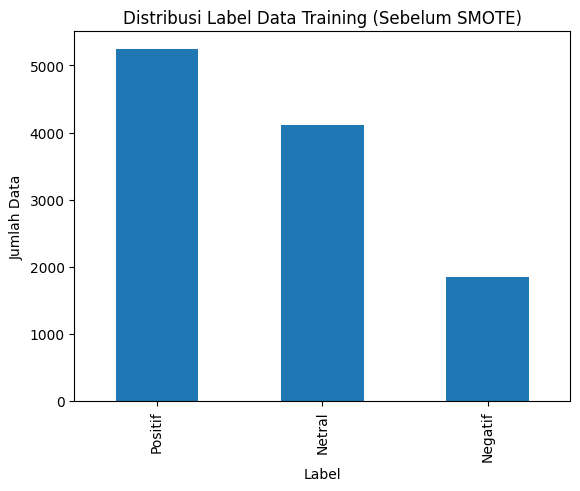

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.title('Distribusi Label Data Training (Sebelum SMOTE)')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()


Distribusi label data TRAIN (setelah SMOTE):
Label
Netral     5245
Negatif    5245
Positif    5245
Name: count, dtype: int64


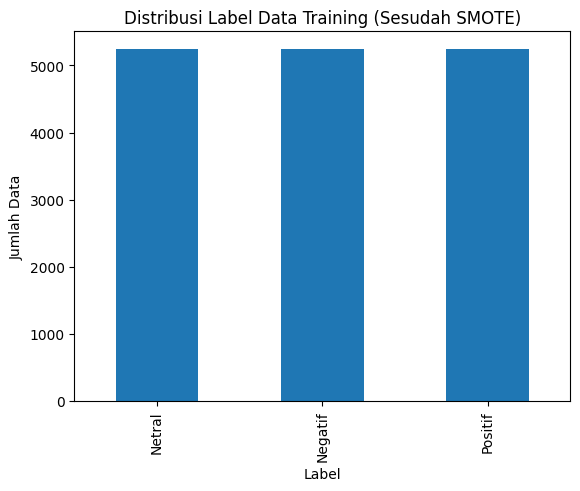

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nDistribusi label data TRAIN (setelah SMOTE):")
print(pd.Series(y_train_smote).value_counts())

y_train_smote.value_counts().plot(kind='bar')
plt.title('Distribusi Label Data Training (Sesudah SMOTE)')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

MODELING & SELEKSI TIPE VOTING TERBAIK

In [ ]:
# Model dasar
knn = KNeighborsClassifier(n_neighbors=5)
nb = MultinomialNB()
svm = SVC(kernel='linear', probability=True)

models = {
    'KNN': knn,
    'NaiveBayes': nb,
    'SVM': svm
}

# Evaluasi model tunggal (Macro F1)
f1_base = {}

for nama, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_base[nama] = f1

    print(f"\nModel {nama}")
    print(classification_report(y_test, y_pred))



Model KNN
              precision    recall  f1-score   support

     Negatif       0.23      0.83      0.36       463
      Netral       0.61      0.42      0.50      1027
     Positif       0.90      0.26      0.41      1312

    accuracy                           0.41      2802
   macro avg       0.58      0.51      0.42      2802
weighted avg       0.68      0.41      0.43      2802


Model NaiveBayes
              precision    recall  f1-score   support

     Negatif       0.38      0.63      0.47       463
      Netral       0.64      0.52      0.57      1027
     Positif       0.81      0.75      0.78      1312

    accuracy                           0.64      2802
   macro avg       0.61      0.63      0.61      2802
weighted avg       0.68      0.64      0.65      2802


Model SVM
              precision    recall  f1-score   support

     Negatif       0.39      0.60      0.47       463
      Netral       0.67      0.56      0.61      1027
     Positif       0.87      0.81  

Hard Voting

In [ ]:
voting_hard = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('nb', nb),
        ('svm', svm)
    ],
    voting='hard'
)

voting_hard.fit(X_train_smote, y_train_smote)
y_pred_hard = voting_hard.predict(X_test)
f1_hard = f1_score(y_test, y_pred_hard, average='macro')

Soft Voting

In [ ]:
voting_soft = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('nb', nb),
        ('svm', svm)
    ],
    voting='soft'
)

voting_soft.fit(X_train_smote, y_train_smote)
y_pred_soft = voting_soft.predict(X_test)
f1_soft = f1_score(y_test, y_pred_soft, average='macro')

Pemilihan Voting Terbaik

In [ ]:
if f1_soft > f1_hard:
    best_model = voting_soft
    best_pred = y_pred_soft
    best_type = 'Soft Voting'
else:
    best_model = voting_hard
    best_pred = y_pred_hard
    best_type = 'Hard Voting'

print("\nVoting terbaik berdasarkan Macro F1:", best_type)
print("F1 Hard Voting :", f1_hard)
print("F1 Soft Voting :", f1_soft)


Voting terbaik berdasarkan Macro F1: Soft Voting
F1 Hard Voting : 0.6026470173421855
F1 Soft Voting : 0.6357559870270179


EVALUASI MODEL

In [ ]:
y_pred = best_model.predict(X_test)


print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Negatif       0.37      0.70      0.49       463
      Netral       0.68      0.57      0.62      1027
     Positif       0.89      0.72      0.80      1312

    accuracy                           0.66      2802
   macro avg       0.65      0.67      0.64      2802
weighted avg       0.73      0.66      0.68      2802



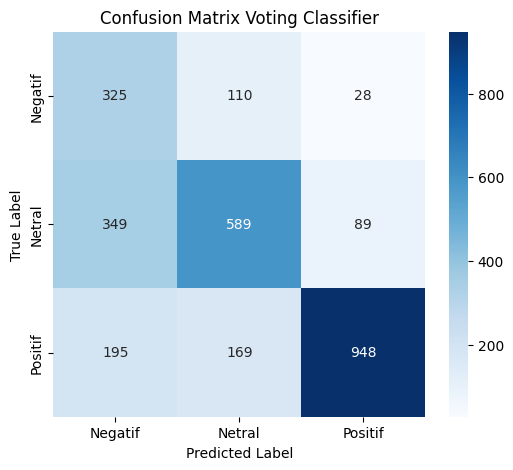

In [ ]:
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=labels,
yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Voting Classifier')
plt.show()

/tmp/ipython-input-2247691368.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


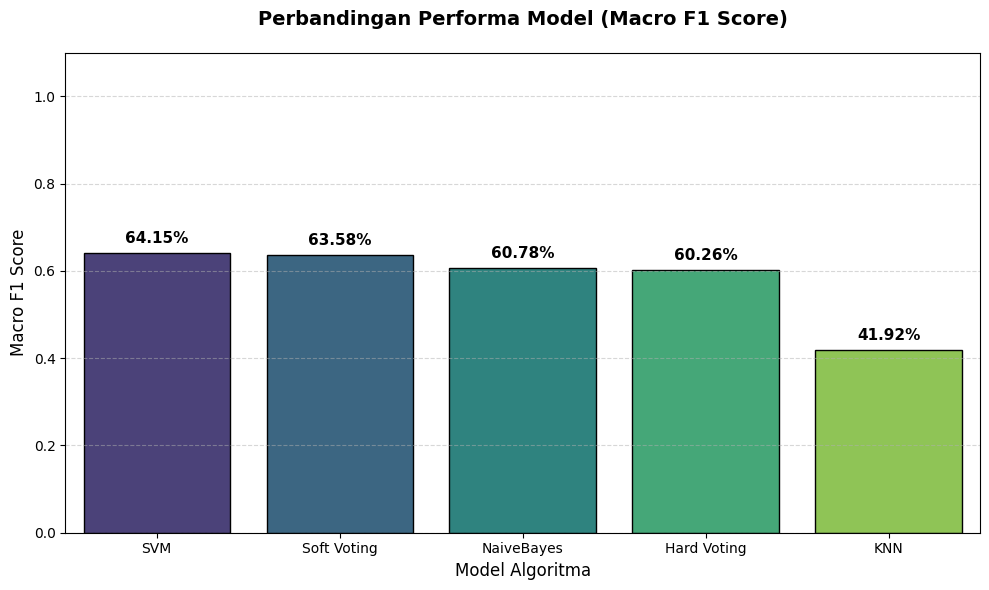


=== RINGKASAN PERFORMA ===
      Model  Macro F1 Score
        SVM        0.641549
Soft Voting        0.635756
 NaiveBayes        0.607801
Hard Voting        0.602647
        KNN        0.419222


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. GABUNGKAN DATA SKOR ---
# Mengambil skor model tunggal yang sudah disimpan di dictionary 'f1_base'
# dan menambahkan skor Hard & Soft Voting
all_scores = f1_base.copy()
all_scores['Hard Voting'] = f1_hard
all_scores['Soft Voting'] = f1_soft

# Ubah ke DataFrame agar mudah di-plot
df_scores = pd.DataFrame(list(all_scores.items()), columns=['Model', 'Macro F1 Score'])

# Urutkan dari skor tertinggi ke terendah agar grafik rapi
df_scores = df_scores.sort_values(by='Macro F1 Score', ascending=False)

# --- 2. BUAT VISUALISASI ---
plt.figure(figsize=(10, 6))

# Plot Bar Chart
ax = sns.barplot(
    data=df_scores,
    x='Model',
    y='Macro F1 Score',
    palette='viridis',
    edgecolor='black'
)

# --- 3. PERCANTIK TAMPILAN ---
plt.title('Perbandingan Performa Model (Macro F1 Score)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model Algoritma', fontsize=12)
plt.ylabel('Macro F1 Score', fontsize=12)
plt.ylim(0, 1.1)  # Set batas Y agar ada ruang untuk label angka
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- 4. TAMBAHKAN ANGKA DI ATAS BATANG ---
for p in ax.patches:
    # Mengambil tinggi batang (nilai skor)
    score = p.get_height()
    # Menulis teks di atas batang
    ax.annotate(f'{score:.2%}',
                (p.get_x() + p.get_width() / 2., score),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black',
                xytext=(0, 5), textcoords='offset points')

# Tampilkan grafik
plt.tight_layout()
plt.show()

# --- 5. TAMPILKAN TABEL RINGKASAN TEKS ---
print("\n=== RINGKASAN PERFORMA ===")
print(df_scores.to_string(index=False))